# ML - Fire and Weather Data 2008 - 2020

# Import and Cleaning Data

In [2]:
# Initial Import of Dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import psycopg2 as pg
from collections import Counter

#add path for utility functions
import sys
import os
CURR_DIR = os.getcwd()
UTILITY_DIR = os.path.abspath(os.path.join(CURR_DIR ,"../../utils"))
sys.path.append(UTILITY_DIR)

from GetData import Wildfire, Noaa
import ProcessData as process
from Configuration import globalvariables as _

In [3]:
# External Database Connection
wildfire_instance = Wildfire()

engine = pg.connect(_.db_connection_string)
fire_df = wildfire_instance.import_data(engine)
engine.close()

In [4]:
# Check Data Types
fire_df.dtypes

fire_year          int64
district          object
unit              object
fire_number       object
fire_name         object
legal             object
latitude          object
longitude         object
fuel_model        object
county            object
report_date       object
general_cause     object
odf_acres        float64
total_acres      float64
dtype: object

In [5]:
# Filter fire_year to match weather data 2008 - 2020
fire_df = fire_df[(fire_df['fire_year'] >= 2008) & (fire_df['fire_year'] <= 2020)]


In [6]:
# Confirm Count Matches Fire_weather dataset 
fire_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12577 entries, 3 to 13715
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fire_year      12577 non-null  int64  
 1   district       12577 non-null  object 
 2   unit           12577 non-null  object 
 3   fire_number    12577 non-null  object 
 4   fire_name      12577 non-null  object 
 5   legal          12573 non-null  object 
 6   latitude       12569 non-null  object 
 7   longitude      12569 non-null  object 
 8   fuel_model     12511 non-null  object 
 9   county         12574 non-null  object 
 10  report_date    12577 non-null  object 
 11  general_cause  12577 non-null  object 
 12  odf_acres      12577 non-null  float64
 13  total_acres    12515 non-null  float64
dtypes: float64(2), int64(1), object(11)
memory usage: 1.4+ MB


In [7]:
#. Check for null values
fire_df.isna().sum()

fire_year         0
district          0
unit              0
fire_number       0
fire_name         0
legal             4
latitude          8
longitude         8
fuel_model       66
county            3
report_date       0
general_cause     0
odf_acres         0
total_acres      62
dtype: int64

In [8]:
# Converting Lat/Long DMS to Decimal
process.convert_decimal_latitude_longitude(fire_df)

fire_df.head(5)

,fire_year,district,unit,fire_number,fire_name,legal,latitude,longitude,fuel_model,county,report_date,general_cause,odf_acres,total_acres
3,2016,55 - West Oregon,Toledo,10,OAR Fire,T7S R11W S23 SWNW,44.953611,-124.007222,J,LINCOLN,2016-08-23,Smoking,0.10,0.10
4,2016,72 - Coos,Bridge,178,Ashur Flat,T31S R9W S30 SENW,42.846111,-123.819167,H,DOUGLAS,2016-06-13,Equipment Use,0.01,0.01
5,2015,53 - Forest Grove,Columbia City,107,Nick Thomas Rd,T6N R2W S10,NaN,NaN,None,COLUMBIA,2015-03-08,Debris Burning,0.25,NaN
6,2014,58 - North Cascade,Molalla,37,CAZADERO,T2S R3E S24 NESW,45.387222,-122.403056,G,CLACKAMAS,2014-08-21,Arson,0.02,0.02
7,2012,71 - Southwest,Medford,64,Buck Flat,T34S R02W S04 NENE,42.648611,-122.935833,C,JACKSON,2012-07-17,Lightning,0.01,0.01


In [9]:
# Drop odf_acres
fire_df = fire_df.drop(["odf_acres"], axis=1)
# Confirm Dropped Columns
fire_df.head(5)

,fire_year,district,unit,fire_number,fire_name,legal,latitude,longitude,fuel_model,county,report_date,general_cause,total_acres
3,2016,55 - West Oregon,Toledo,10,OAR Fire,T7S R11W S23 SWNW,44.953611,-124.007222,J,LINCOLN,2016-08-23,Smoking,0.10
4,2016,72 - Coos,Bridge,178,Ashur Flat,T31S R9W S30 SENW,42.846111,-123.819167,H,DOUGLAS,2016-06-13,Equipment Use,0.01
5,2015,53 - Forest Grove,Columbia City,107,Nick Thomas Rd,T6N R2W S10,NaN,NaN,None,COLUMBIA,2015-03-08,Debris Burning,NaN
6,2014,58 - North Cascade,Molalla,37,CAZADERO,T2S R3E S24 NESW,45.387222,-122.403056,G,CLACKAMAS,2014-08-21,Arson,0.02
7,2012,71 - Southwest,Medford,64,Buck Flat,T34S R02W S04 NENE,42.648611,-122.935833,C,JACKSON,2012-07-17,Lightning,0.01


In [10]:
# Drop the null columns where all values are null
fire_df = fire_df.dropna(axis='columns', how='all')

# Drop the null rows
fire_df = fire_df.dropna()
fire_df.head(5)

,fire_year,district,unit,fire_number,fire_name,legal,latitude,longitude,fuel_model,county,report_date,general_cause,total_acres
3,2016,55 - West Oregon,Toledo,10,OAR Fire,T7S R11W S23 SWNW,44.953611,-124.007222,J,LINCOLN,2016-08-23,Smoking,0.10
4,2016,72 - Coos,Bridge,178,Ashur Flat,T31S R9W S30 SENW,42.846111,-123.819167,H,DOUGLAS,2016-06-13,Equipment Use,0.01
6,2014,58 - North Cascade,Molalla,37,CAZADERO,T2S R3E S24 NESW,45.387222,-122.403056,G,CLACKAMAS,2014-08-21,Arson,0.02
7,2012,71 - Southwest,Medford,64,Buck Flat,T34S R02W S04 NENE,42.648611,-122.935833,C,JACKSON,2012-07-17,Lightning,0.01
8,2008,72 - Coos,Coos FPA,15,Hedge Lane,T25S R13W S30 SWSW,43.368331,-124.295000,F,COOS,2008-07-28,Smoking,0.01


In [11]:
fire_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12504 entries, 3 to 13715
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fire_year      12504 non-null  int64  
 1   district       12504 non-null  object 
 2   unit           12504 non-null  object 
 3   fire_number    12504 non-null  object 
 4   fire_name      12504 non-null  object 
 5   legal          12504 non-null  object 
 6   latitude       12504 non-null  float64
 7   longitude      12504 non-null  float64
 8   fuel_model     12504 non-null  object 
 9   county         12504 non-null  object 
 10  report_date    12504 non-null  object 
 11  general_cause  12504 non-null  object 
 12  total_acres    12504 non-null  float64
dtypes: float64(3), int64(1), object(9)
memory usage: 1.3+ MB


In [14]:
# Import LE to convert Fuel Model and General Cause to Numeric Values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Converting Fuel Model to Numeric
label_encoder = LabelEncoder()
fire_df["fueltype_num"] = label_encoder.fit_transform(fire_df["fuel_model"])

,fire_year,district,unit,fire_number,fire_name,legal,latitude,longitude,fuel_model,county,report_date,general_cause,total_acres,fueltype_num
3,2016,55 - West Oregon,Toledo,10,OAR Fire,T7S R11W S23 SWNW,44.953611,-124.007222,J,LINCOLN,2016-08-23,Smoking,0.10,7
4,2016,72 - Coos,Bridge,178,Ashur Flat,T31S R9W S30 SENW,42.846111,-123.819167,H,DOUGLAS,2016-06-13,Equipment Use,0.01,5
6,2014,58 - North Cascade,Molalla,37,CAZADERO,T2S R3E S24 NESW,45.387222,-122.403056,G,CLACKAMAS,2014-08-21,Arson,0.02,4
7,2012,71 - Southwest,Medford,64,Buck Flat,T34S R02W S04 NENE,42.648611,-122.935833,C,JACKSON,2012-07-17,Lightning,0.01,2
8,2008,72 - Coos,Coos FPA,15,Hedge Lane,T25S R13W S30 SWSW,43.368331,-124.295000,F,COOS,2008-07-28,Smoking,0.01,3


In [12]:
# Alternative Model with 7 CLasses - Set and Classify Fire Sizes - https://www.nwcg.gov/term/glossary/size-class-of-fire
#fire_df.loc[fire_df['total_acres'] <= .25, 'fire_severity'] = 1
#fire_df.loc[(fire_df['total_acres'] > .25) & (fire_df['total_acres'] <= 10), 'fire_severity'] = 2
#fire_df.loc[(fire_df['total_acres'] > 10) & (fire_df['total_acres'] <= 100), 'fire_severity'] = 3
#fire_df.loc[(fire_df['total_acres'] > 100) & (fire_df['total_acres'] <= 300), 'fire_severity'] = 4
#fire_df.loc[(fire_df['total_acres'] > 300) & (fire_df['total_acres'] <= 1000), 'fire_severity'] = 5
#fire_df.loc[(fire_df['total_acres'] > 1000) & (fire_df['total_acres'] <= 5000), 'fire_severity'] = 6
#fire_df.loc[fire_df['total_acres'] > 5000, 'fire_severity'] = 7                                                   

Text(0.5, 0, 'total acres')

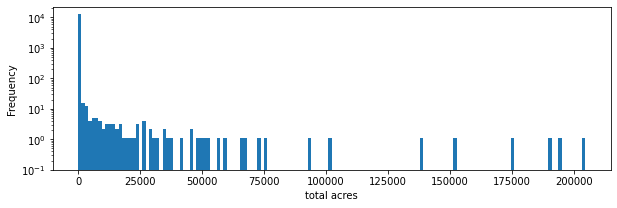

In [24]:
fig, ax = plt.subplots()
fire_df['total_acres'].plot.hist(ax=ax, bins=150, bottom=0.1, figsize=(10,3))
ax.set_yscale('log')
ax.set_xlabel('total acres')

In [15]:
# Set and Classify Fire Sizes - https://www.nwcg.gov/term/glossary/size-class-of-fire
fire_df.loc[fire_df['total_acres'] <= .25, 'fire_severity'] = 1
fire_df.loc[(fire_df['total_acres'] > .25) & (fire_df['total_acres'] <= 300), 'fire_severity'] = 2
fire_df.loc[fire_df['total_acres'] > 300, 'fire_severity'] = 3      
fire_df.head()    

,fire_year,district,unit,fire_number,fire_name,legal,latitude,longitude,fuel_model,county,report_date,general_cause,total_acres,fueltype_num,fire_severity
3,2016,55 - West Oregon,Toledo,10,OAR Fire,T7S R11W S23 SWNW,44.953611,-124.007222,J,LINCOLN,2016-08-23,Smoking,0.10,7,1.0
4,2016,72 - Coos,Bridge,178,Ashur Flat,T31S R9W S30 SENW,42.846111,-123.819167,H,DOUGLAS,2016-06-13,Equipment Use,0.01,5,1.0
6,2014,58 - North Cascade,Molalla,37,CAZADERO,T2S R3E S24 NESW,45.387222,-122.403056,G,CLACKAMAS,2014-08-21,Arson,0.02,4,1.0
7,2012,71 - Southwest,Medford,64,Buck Flat,T34S R02W S04 NENE,42.648611,-122.935833,C,JACKSON,2012-07-17,Lightning,0.01,2,1.0
8,2008,72 - Coos,Coos FPA,15,Hedge Lane,T25S R13W S30 SWSW,43.368331,-124.295000,F,COOS,2008-07-28,Smoking,0.01,3,1.0


In [25]:
# Loss in data from additional null fields in weather data
print(fire_df['fire_severity'].value_counts())

1.0    8947
2.0    3384
3.0     173
Name: fire_severity, dtype: int64


In [26]:
fire_df.general_cause.unique()

array(['Smoking', 'Equipment Use', 'Arson', 'Lightning', 'Miscellaneous',
       'Debris Burning', 'Juveniles', 'Recreationist', 'Under Invest',
       'Railroad'], dtype=object)

In [27]:
# Change General Cause Human or Nature

fire_df['general_cause'] = fire_df['general_cause'].replace(['Recreationist','Equipment Use','Debris Burning', 'Smoking', 'Arson', 'Railroad', 'Juveniles'],'1')
fire_df['general_cause'] = fire_df['general_cause'].replace(['Lightning'],'2')
fire_df['general_cause'] = fire_df['general_cause'].replace(['Under Invest', 'Miscellaneous'],'3')


#  Random Forest Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [29]:
fire_binary_encoded = pd.get_dummies(fire_df, columns=["fuel_model", "general_cause"])
fire_binary_encoded.head()

,fire_year,district,unit,fire_number,fire_name,legal,latitude,longitude,county,report_date,...,fuel_model_J,fuel_model_K,fuel_model_L,fuel_model_R,fuel_model_T,fuel_model_U,fuel_model_X,general_cause_1,general_cause_2,general_cause_3
3,2016,55 - West Oregon,Toledo,10,OAR Fire,T7S R11W S23 SWNW,44.953611,-124.007222,LINCOLN,2016-08-23,...,1,0,0,0,0,0,0,1,0,0
4,2016,72 - Coos,Bridge,178,Ashur Flat,T31S R9W S30 SENW,42.846111,-123.819167,DOUGLAS,2016-06-13,...,0,0,0,0,0,0,0,1,0,0
6,2014,58 - North Cascade,Molalla,37,CAZADERO,T2S R3E S24 NESW,45.387222,-122.403056,CLACKAMAS,2014-08-21,...,0,0,0,0,0,0,0,1,0,0
7,2012,71 - Southwest,Medford,64,Buck Flat,T34S R02W S04 NENE,42.648611,-122.935833,JACKSON,2012-07-17,...,0,0,0,0,0,0,0,0,1,0
8,2008,72 - Coos,Coos FPA,15,Hedge Lane,T25S R13W S30 SWSW,43.368331,-124.295000,COOS,2008-07-28,...,0,0,0,0,0,0,0,1,0,0


In [30]:
fire_binary_encoded = fire_binary_encoded.drop(['fueltype_num','district', 'unit', "fire_name", "legal", "report_date","fire_number", "county", "total_acres" ], axis=1)

In [31]:
fire_binary_encoded.head()

,fire_year,latitude,longitude,fire_severity,fuel_model_A,fuel_model_B,fuel_model_C,fuel_model_F,fuel_model_G,fuel_model_H,...,fuel_model_J,fuel_model_K,fuel_model_L,fuel_model_R,fuel_model_T,fuel_model_U,fuel_model_X,general_cause_1,general_cause_2,general_cause_3
3,2016,44.953611,-124.007222,1.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,2016,42.846111,-123.819167,1.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
6,2014,45.387222,-122.403056,1.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
7,2012,42.648611,-122.935833,1.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,2008,43.368331,-124.295000,1.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [32]:
# Define the features set.
X = fire_binary_encoded
X = X.drop("fire_severity", axis=1)
X.head()

,fire_year,latitude,longitude,fuel_model_A,fuel_model_B,fuel_model_C,fuel_model_F,fuel_model_G,fuel_model_H,fuel_model_I,fuel_model_J,fuel_model_K,fuel_model_L,fuel_model_R,fuel_model_T,fuel_model_U,fuel_model_X,general_cause_1,general_cause_2,general_cause_3
3,2016,44.953611,-124.007222,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,2016,42.846111,-123.819167,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
6,2014,45.387222,-122.403056,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
7,2012,42.648611,-122.935833,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,2008,43.368331,-124.295000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [33]:
# Define the target set.
y = fire_binary_encoded["fire_severity"].ravel()
y[:5]

array([1., 1., 1., 1., 1.])

In [34]:
# Splitting into Train and Test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [35]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [36]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=100, random_state=78) 

In [37]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [38]:
predictions = rf_model.predict(X_test_scaled)

In [39]:
predictions

array([1., 1., 1., ..., 1., 1., 1.])

In [40]:
# Calculate feature importance in the Random Forest model.
importances = rf_model.feature_importances_
importances

array([0.14482542, 0.37160452, 0.38158204, 0.00836932, 0.00190733,
       0.00789437, 0.00615864, 0.00485301, 0.00671278, 0.00452144,
       0.00608264, 0.00413454, 0.007421  , 0.00373713, 0.00335087,
       0.00302688, 0.014739  , 0.00731579, 0.006444  , 0.00531928])

In [41]:
# Features Sorted by Importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.3815820448823148, 'longitude'),
 (0.37160451800122446, 'latitude'),
 (0.14482541891658368, 'fire_year'),
 (0.01473900034074117, 'fuel_model_X'),
 (0.008369322252505713, 'fuel_model_A'),
 (0.0078943732973427, 'fuel_model_C'),
 (0.00742099775198451, 'fuel_model_L'),
 (0.007315791730552583, 'general_cause_1'),
 (0.006712778493125965, 'fuel_model_H'),
 (0.0064440039134755715, 'general_cause_2'),
 (0.006158642031039745, 'fuel_model_F'),
 (0.006082635799401574, 'fuel_model_J'),
 (0.005319280125837919, 'general_cause_3'),
 (0.004853008345479589, 'fuel_model_G'),
 (0.004521437736397455, 'fuel_model_I'),
 (0.004134535279168569, 'fuel_model_K'),
 (0.0037371275132057243, 'fuel_model_R'),
 (0.0033508693130262887, 'fuel_model_T'),
 (0.0030268815425131984, 'fuel_model_U'),
 (0.0019073327340788204, 'fuel_model_B')]

In [31]:
# Legend For Fuel Models
#A	Annual grasses (cheat)
#B	Dense Chaparral
#C	Open pine, grass under
#F	Dense Brush (lighter than B)
#G	Conifer, Old growth
#H	Conifer, Second growth
#I	Slash, heavy
#J	Slash, medium
#K	Slash, thinning, P.C., Scattrd
#L	Grass Perennial
#R	Hardwood, summer
#T	Sagebrush, medium dense
#U	Closed canopy pine
#X	Non wildland fuel

In [32]:
# Legend For General Cause
# 1 = Human
# 2 = Nature
# 3 = Uncategorized

In [33]:
# Conusion Matrix to predict fire severity 
cm = confusion_matrix(y_test, predictions)
# DataFrame from the confusion matrix.
cm_df = pd.DataFrame(cm, index=["Class 1", "Class 2","Class 3"], columns=["Predicted 1", "Predicted 2","Predicted 3"])
cm_df

,Predicted 1,Predicted 2,Predicted 3
Class 1,1685,129,2
Class 2,511,153,0
Class 3,22,10,0


In [34]:
#Class 1 - one-quarter acre or less;
#Class 2 - more than one-quarter acre, but less than 300 acres;
#Class 3 - 300 acres or more.

In [35]:
#  # Alternative Model with 7 CLasses Conusion Matrix to predict fire severity 
#cm = confusion_matrix(y_test, predictions)
# DataFrame from the confusion matrix.
#cm_df = pd.DataFrame(cm, index=["Class 1", "Class 2","Class 3","Class 4","Class 5", "Class 6", "Class 7"], columns=["Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5", "Predicted 6","Predicted 7"])
#cm_df

In [36]:
#Class 1 - one-fourth acre or less;
#Class 2 - more than one-fourth acre, but less than 10 acres;
#Class 3 - 10 acres or more, but less than 100 acres;
#Class 4 - 100 acres or more, but less than 300 acres;
#Class 5 - 300 acres or more, but less than 1,000 acres;
#Class 6 - 1,000 acres or more, but less than 5,000 acres;
#Class 7 - 5,000 acres or more.

In [37]:
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, predictions)

In [38]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 1,Predicted 2,Predicted 3
Class 1,1685,129,2
Class 2,511,153,0
Class 3,22,10,0


Accuracy Score : 0.731687898089172
Classification Report
              precision    recall  f1-score   support

         1.0       0.76      0.93      0.84      1816
         2.0       0.52      0.23      0.32       664
         3.0       0.00      0.00      0.00        32

    accuracy                           0.73      2512
   macro avg       0.43      0.39      0.39      2512
weighted avg       0.69      0.73      0.69      2512



# Combination Sampling With SMOTEENN

In [39]:
fire_smoteen = fire_df.drop(['district','fuel_model', 'unit', "fire_name", "legal", "report_date","fire_number", "county", "total_acres" ], axis=1)
fire_smoteen.head(5)

,fire_year,general_cause,prcp_avg,snow_avg,snwd_avg,tmax_avg,tmin_avg,Latitude,Longitude,fueltype_num,fire_severity
1,2008,1,0.003077,0.0,20.000000,56.750000,38.000000,44.814719,-123.376389,9,2.0
2,2008,1,0.001538,0.0,0.000000,62.833333,40.500000,42.897219,-124.083061,3,1.0
5,2008,1,0.514000,0.0,0.000000,45.500000,36.833333,45.628061,-123.933611,5,1.0
8,2008,1,0.000000,0.0,12.500000,79.375000,39.750000,42.118061,-123.687781,5,2.0
10,2008,1,0.000000,0.0,35.714286,64.000000,33.000000,45.603331,-117.727500,2,1.0


In [40]:
x_cols = [i for i in fire_smoteen.columns if i not in ('fire_severity')]
X = fire_smoteen[x_cols]
y = fire_smoteen['fire_severity']

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [42]:
from imblearn.combine import SMOTEENN
smoteenn = SMOTEENN(random_state=1)
X_resampled, y_resampled = smoteenn.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({1.0: 2020, 2.0: 3309, 3.0: 5257})

In [43]:
from sklearn.linear_model import LogisticRegression
smoteen_model = LogisticRegression(solver='lbfgs',max_iter=100)
smoteen_model.fit(X_resampled, y_resampled)

/Users/michaelfreel/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [44]:
from sklearn.metrics import confusion_matrix
y_pred = smoteen_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[319, 703, 776],
       [ 70, 291, 318],
       [  0,   2,  33]])

In [45]:
#from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import balanced_accuracy_score
y_pred = smoteen_model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5162826420890937

In [46]:
# Display the confusion matrix
smoteen_cm = confusion_matrix(y_test, y_pred)
# DataFrame from the confusion matrix.
smoteen_cm_df = pd.DataFrame(cm, index=["Class 1", "Class 2","Class 3"], columns=["Predicted 1", "Predicted 2","Predicted 3"])
smoteen_cm_df

,Predicted 1,Predicted 2,Predicted 3
Class 1,1685,129,2
Class 2,511,153,0
Class 3,22,10,0


In [47]:
# # Alternative Model with 7 CLasses - Display the confusion matrix
#smoteen_cm = confusion_matrix(y_test, y_pred)
# DataFrame from the confusion matrix.
#smoteen_cm_df = pd.DataFrame(cm, index=["Class 1", "Class 2","Class 3","Class 4","Class 5", "Class 6", "Class 7"], columns=["Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5", "Predicted 6","Predicted 7"])
#smoteen_cm_df

In [48]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.82      0.18      0.90      0.29      0.40      0.15      1798
        2.0       0.29      0.43      0.62      0.35      0.51      0.26       679
        3.0       0.03      0.94      0.56      0.06      0.73      0.55        35

avg / total       0.67      0.26      0.82      0.30      0.44      0.18      2512

